In [1]:
#first execute /albedo/home/orichter/develPaperPlots/writeNetCDFMiso.m to generate VAF.nc

import xarray as xr
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import glob
import pickle
import matplotlib
#from scipy import io

sys.path.append("../pyfesom")
import pyfesom as pf

#from matplotlib.colors import LinearSegmentedColormap
#import numpy as np
#from matplotlib import cm
from netCDF4 import Dataset

basedir = '/albedo/work/projects/oce_rio/orichter/uacpl/'

No joblib
cartopy is not avalible, plotting will not work


# Change in gr. Area and VAF

In [10]:
def get_center_ax(ax,exp,label=None,resultsPath=None):
    if resultsPath==None:
        resultsPath = os.path.join(basedir,'postprocessing',exp,'VAF.nc')
    da = xr.open_dataset(resultsPath)
    GLC = xr.DataArray(np.zeros_like(da.nTime),dims=('nTime'))
    for time in range(da.nTime.size):
        idx = (np.abs(da.yGL[time] - 40000)).argmin()
        GLC[time]=da.xGL[time][idx]/1000
    time = da.time[:]-1000
    if label==None:
        label=exp
    ax.plot(time,GLC,label=label,color='k')
    ax.set_xlabel('Time in Years')
    ax.set_ylabel('GL position at center (km)')
    return ax

def grAreaChange(da):
    return (da.groundedArea-da.groundedArea[0])*1e-9

def get_grAreaChange_ax(ax,exp,label=None,resultsPath=None):
    if resultsPath==None:
        resultsPath = os.path.join(basedir,'postprocessing',exp,'VAF.nc')
    da = xr.open_dataset(resultsPath)
    grAreaCh = grAreaChange(da)
    time = da.time[:]-1000
    if label==None:
        label=exp
    ax.plot(time,grAreaCh,label=label,color='k')
    ax.set_xlabel('Time in Years')
    ax.set_ylabel('Change in Grounded Area (10$^3$ km$^2$)')
    return ax

def get_grArea_ax(ax,exp,label=None,resultsPath=None,color='k',alpha=1):
    if resultsPath==None:
        resultsPath = os.path.join(basedir,'postprocessing',exp,'VAF.nc')
    da = xr.open_dataset(resultsPath)
    time = da.time[:]-1000
    grArea=da.groundedArea*1e-9
    if label==None:
        label=exp
    ax.plot(time,da.groundedArea*1e-9,label=label,color=color,alpha=alpha)
    ax.set_xlabel('Time in Years')
    ax.set_ylabel('Ice Grounded Area (10$^3$ km$^2$)')
    return ax,grArea

def get_VAFChange_ax(ax,exp,label=None):
    resultsPath = os.path.join(basedir,'postprocessing',exp,'VAF.nc')
    da = xr.open_dataset(resultsPath)
    VAF = (da.iceVAF-da.iceVAF[0])*1e-9
    time = da.time[:]-1000
    if label==None:
        label=exp
    ax.plot(time,VAF,label=label,color='k')
    ax.set_xlabel('Time in Years')
    ax.set_ylabel('Change in Volume Above Flotation (km$^3$)')
    return ax

def get_VAF_ax(ax,exp,label=None,color='k',alpha=1):
    resultsPath = os.path.join(basedir,'postprocessing',exp,'VAF.nc')
    da = xr.open_dataset(resultsPath)
    VAF = da.iceVAF*1e-12
    time = da.time[:]-1000
    if label==None:
        label=exp
    ax.plot(time,VAF,label=label,color=color,alpha=alpha)
    ax.set_xlabel('Time in Years')
    ax.set_ylabel('Ice Volume Above Flotation (10$^3$ km$^3$)')
    return ax,VAF


def get_iceVol_ax(ax,exp,label=None):
    resultsPath = os.path.join(basedir,'postprocessing',exp,'VAF.nc')
    da = xr.open_dataset(resultsPath)
    VAF = da.iceVolume*1e-12
    time = da.time[:]-1000
    if label==None:
        label=exp
    ax.plot(time,VAF,label=label,color='k')
    ax.set_xlabel('Time in Years')
    ax.set_ylabel('Ice Volume (10$^3$ km$^3$)')
    return ax

def get_bmbIce_ax(ax,exp,label=None,color='k',alpha=1):
    resultsPath = os.path.join(basedir,'postprocessing',exp,'VAF.nc')
    da = xr.open_dataset(resultsPath)
    bmb = 0.5*(da.basalMassBalance.values[1:]+da.basalMassBalance.values[:-1])
    time = da.time[:-1]-1000
    if label==None:
        label=exp
    ax.plot(time,-bmb,label=label,color=color,alpha=alpha)
    ax.set_xlabel('Time in Years')
    ax.set_ylabel('Total Melt Flux (Gt/yr)')
    return ax,time,-bmb

def get_bmbOce(exp,years,yearfrac=True):
    bmbTempFile = os.path.join(basedir,'postprocessing',exp,'bmb.pkl')
    if os.path.isfile(bmbTempFile):
        with open(bmbTempFile, 'rb') as fp:
            bmb = pickle.load(fp)
            print('Done reading bmb file')
        return bmb
    else:
        rhofw = 1000
        s2a = 3600*24*365.25
        kg2gt = 1e-12
        scratchdir='/isibhv/netscratch/orichter/'
        bmb = []
        t=[]
        for year in years:
            year_out = str(year-1000).zfill(3)
            if yearfrac:
                year = "{:.2f}".format(year)
            year=str(year)
            print(year)
            meshPath  = os.path.join(scratchdir,'timmsmesh',exp,year)
            mesh = pf.fesom_mesh(meshPath, abg=[0,0,0],cavity=False)
            fileName =  "%s.%s.forcing.diag.nc" %(exp,year)
            filePath=os.path.join(scratchdir,'timmsdata',exp,fileName)
            fl = Dataset(filePath)
            mdpath = os.path.join(scratchdir,'timmsdata',exp,exp+'.'+year+'.mesh.diag.nc')
            md = xr.open_dataset(mdpath)
            mask = (mesh.cflag==1)
            area=md.cluster_area[0,mask]
            #pdb.set_trace()
            melt = np.mean(fl['wnet'][-12:,mask],0)
            #melt = fl['wnet'][:].squeeze()
            #area = mesh.voltri[0:mesh.n2d][mask]
            bmb.append(np.sum(melt*area)*rhofw*s2a*kg2gt) 
            t.append(year_out)
        with open(bmbTempFile, 'wb') as fp:
            pickle.dump(bmb_oce, fp)
            print('Done writing bmb into a binary file')
        return bmb
    
def get_bmbCumComp_ax(ax,bmb_ice,bmb_oce,time):
    ax.plot(time,np.cumsum(bmb_ice)*1e-3,label='ice',color='k')
    ax.set_xlabel('Time in Years')
    ax.set_ylabel('Cumulative Melt Flux (10$^3$ Gt)')
    ax.legend(loc=2)
    
    ax1=ax.twinx()
    ax1.plot(np.cumsum(bmb_ice[:-1]-bmb_oce[1:]),'red',alpha=0.5,label='ice-ocean')
    ax1.set_ylabel('Cumulative Melt Flux Difference (Gt)')
    ax1.yaxis.label.set_color('red')
    ax1.tick_params(axis='y', colors='red')
    ax.set_xlabel('Time in Years')
    ax1.legend()
    return ax

In [3]:
def fesom2miso(exp,years,outpath=False):
    global misoGrd, mask4d, basedir
    
    basedir = '/isibhv/netscratch/orichter/'

    mr=[0]*np.size(years)
    vol=[0]*np.size(years)
    mt=[0]*np.size(years)
    ms=[0]*np.size(years)
    
    for i,year in enumerate(years):
        print('processing year '+str(year-1000))
        
        rhofw = 1000   
        year_key ="{:.2f}".format(year)

        meshpath = os.path.join(basedir,'timmsmesh',exp,year_key)
        mesh = pf.fesom_mesh(meshpath, abg=[0,0,0],cavity=False,get3d=True)

        mdpath = os.path.join(basedir,'timmsdata',exp,exp+'.'+year_key+'.mesh.diag.nc')
        md = xr.open_dataset(mdpath).sel(T=0)

        dpath = os.path.join(basedir,'timmsdata',exp,exp+'.'+year_key+'.forcing.diag.nc')
        frc = xr.open_dataset(dpath)
        if frc.time.size==13:
            frc=frc.sel(T=np.arange(1,13))

        dpath = os.path.join(basedir,'timmsdata',exp,exp+'.'+year_key+'.oce.mean.nc')
        ocem = xr.open_dataset(dpath)  
        if ocem.time.size==13:
            ocem=ocem.sel(T=np.arange(1,13))
        area = md.cluster_area[mesh.cflag==1]
        weights = area/area.sum()
        
        mr[i] = np.mean(np.sum(frc.wnet[:,mesh.cflag==1]*weights,1)).values*365.25*3600*24
        vol[i] = md.cluster_vol.sum()/10**12
        
        weights = md.cluster_vol/md.cluster_vol.sum()
        ms[i] = np.mean(np.sum(ocem.salt*weights,1))
        mt[i] = np.mean(np.sum(ocem.temp*weights,1))
        #pdb.set_trace()
    ds = xr.Dataset(
          {
              "meanMeltRate":(['nTime'],mr),
              #"totalMeltFlux":(['nTime'],mf),
              'totalOceanVolume':(['nTime'],vol),
              'meanTemperature':(['nTime'],mt),
              'meanSalinity':(['nTime'],ms)
          },
          coords={
              'time':(['nTime'],years-1000)
          })  
            
    if outpath:
        print('saving to '+outpath)
        ds.astype('float32').to_netcdf(outpath)
        #[expt]_COM_[component]_[MODEL_CONFIG].nc

    return ds

In [4]:
def fesom2miso2(exp,years,outpath=False):
    global misoGrd, mask4d, basedir
    
    basedir = '/isibhv/netscratch/orichter/'

    mti=[0]*np.size(years)
    msi=[0]*np.size(years)
    
    for i,year in enumerate(years):
        print('processing year '+str(year-1000))
        
        if year==1199:
            year=year-1
        
        rhofw = 1000   
        year_key ="{:.2f}".format(year)
        year_key2 ="{:.2f}".format(year+1)

        mdpath = os.path.join(basedir,'timmsdata',exp,exp+'.'+year_key+'.mesh.diag.nc')
        md = xr.open_dataset(mdpath).sel(T=0)

        mdpath = os.path.join(basedir,'timmsdata',exp,exp+'.'+year_key2+'.mesh.diag.nc')
        md2 = xr.open_dataset(mdpath).sel(T=0)

        dpath = os.path.join(basedir,'timmsdata',exp,exp+'.'+year_key+'.oce.mean.nc')
        ocem = xr.open_dataset(dpath)
        ocem = ocem.sel(T=ocem.T.size-1)
        
        dpath = os.path.join(basedir,'timmsdata',exp,exp+'.'+year_key2+'.oce.ini.nc')
        ocem2 = xr.open_dataset(dpath)
        
        weights = md.cluster_vol/md.cluster_vol.sum()
        weights2 = md2.cluster_vol/md2.cluster_vol.sum()
        
        ms=np.sum(ocem.salt*weights)
        ms2=np.sum(ocem2.salt*weights2)
        
        mt=np.sum(ocem.temp*weights)
        mt2=np.sum(ocem2.temp*weights2)
        
        msi[i]=ms2-ms
        mti[i]=mt2-mt
        
        
        
        #pdb.set_trace()
    ds = xr.Dataset(
          {
              #"meanMeltRate":(['nTime'],mr),
              #"totalMeltFlux":(['nTime'],mf),
              #'totalOceanVolume':(['nTime'],vol),
              'meanTemperatureMistake':(['nTime'],mti),
              'meanSalinityMistake':(['nTime'],msi)
          },
          coords={
              'time':(['nTime'],years-1000)
          })  
            
    if outpath:
        print('saving to '+outpath)
        ds.astype('float32').to_netcdf(outpath)
        #[expt]_COM_[component]_[MODEL_CONFIG].nc

    return ds



In [5]:
ds_path='/albedo/work/projects/oce_rio/orichter/uacpl/postprocessing/io1056/oceanIntMistake.nc'
#ds2 =fesom2miso2('io1056',np.arange(1000,1199),'/albedo/work/projects/oce_rio/orichter/uacpl/postprocessing/io1056/oceanIntMistake.nc')
ds2=xr.open_dataset(ds_path)
ds_path='/albedo/work/projects/oce_rio/orichter/uacpl/postprocessing/io1056/oceanInt.nc'
#ds2 =fesom2miso('io1056',np.arange(1000,1199),'/albedo/work/projects/oce_rio/orichter/uacpl/postprocessing/io1056/oceanInt.nc')
ds=xr.open_dataset(ds_path)
ds = ds.isel(nTime=slice(1,199))
ds2 = ds2.isel(nTime=slice(1,199))

Done reading bmb file


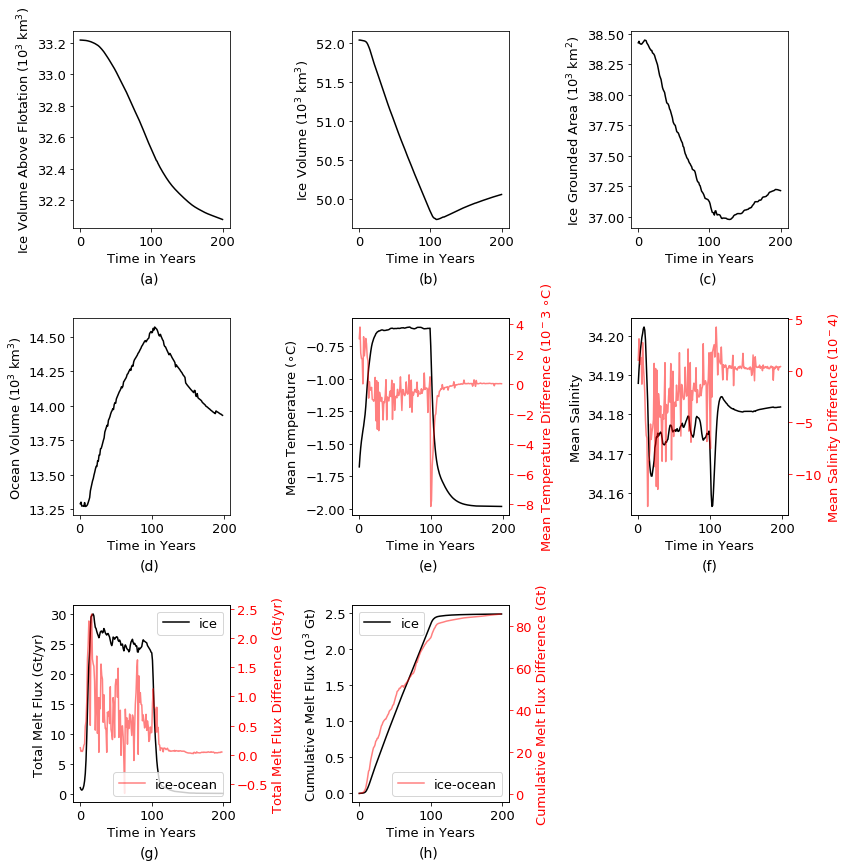

In [11]:
matplotlib.rcParams.update({'font.size': 13})
basedir = '/albedo/work/projects/oce_rio/orichter/uacpl/'

tc='red'

fig,axes = plt.subplots(nrows=3,ncols=3,figsize=(12,12))

ax0,ax1,ax2=axes[0,:].flatten()

ax0=get_VAF_ax(ax0,'io1056','')
ax1=get_iceVol_ax(ax1,'io1056','')
ax2=get_grArea_ax(ax2,'io1056','')


ax0,ax1,ax2=axes[1,:].flatten()

ax0.plot(ds.time,ds.totalOceanVolume,'k')
ax0.set_xlabel('Time in Years')
ax0.set_ylabel('Ocean Volume ($10^3$ km$^3$)')


ax1.plot(ds.time,ds.meanTemperature,'k')
ax1.set_xlabel('Time in Years')
ax1.set_ylabel('Mean Temperature ($\circ$C)')

ax12=ax1.twinx()
ax12.plot(ds2.time,ds2.meanTemperatureMistake*1e3,'red',alpha=0.5)
ax12.set_ylabel('Mean Temperature Difference ($10^-3$ $\circ$C)')
ax12.yaxis.label.set_color('red')
ax12.tick_params(axis='y', colors='red')

ax2.plot(ds.time,ds.meanSalinity,'k')
ax2.set_xlabel('Time in Years')
ax2.set_ylabel('Mean Salinity')

ax21=ax2.twinx()
ax21.plot(ds2.time,ds2.meanSalinityMistake*1e4,'red',alpha=0.5)
ax21.set_ylabel('Mean Salinity Difference ($10^-4$)')
ax21.yaxis.label.set_color('red')
ax21.tick_params(axis='y', colors='red')


ax0,ax1,ax2=axes[2,:].flatten()

ax0,time,bmb_ice = get_bmbIce_ax(ax0,'io1056','ice')
bmb_oce=get_bmbOce('io1056',np.arange(1000,1200,1))
#ax0.plot(bmb_oce[1:],label='ocean')
#ax2.plot(bmb_ice[:-1]-bmb_oce[1:],label='ice-ocean')
ax0.legend(loc=1)

ax01=ax0.twinx()
ax01.plot(bmb_ice[:-1]-bmb_oce[1:],'red',alpha=0.5,label='ice-ocean')
ax01.set_ylabel('Total Melt Flux Difference (Gt/yr)')
ax01.yaxis.label.set_color('red')
ax01.tick_params(axis='y', colors='red')
ax01.legend(loc=4)

ax1=get_bmbCumComp_ax(ax1,bmb_ice,bmb_oce,time)

ax2.axis('off')

#ax0,ax1,ax2,ax3=axes[2,:].flatten()
#ax0=get_center_ax(ax0,'io1056','')

#ax.plot(np.cumsum(bmb_ice[:-2]-bmb_oce),label='cumsum')
for ax,label in zip(axes.flatten(),['(a)', '(b)', '(c)', '(d)','(e)','(f)','(g)','(h)']):
    ax.text(0.55, -0.22, label, transform=ax.transAxes,
      fontsize=14, va='top', ha='right')

plt.tight_layout()
plt.savefig('./figures/idealisedIntegratedQuantitiesOceanAndIce.pdf',bbox_inches='tight',backend='pgf')
plt.show()

In [27]:
ds = ds.isel(nTime=slice(1,199))
ds2 = ds2.isel(nTime=slice(1,199))

2.416056322325826
0.035804342769848806
85.72576899370299


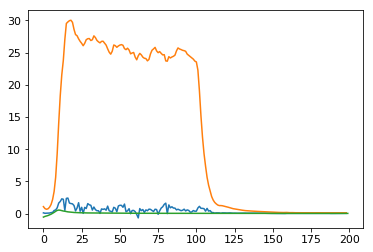

In [48]:
print(max((bmb_ice[:-1]-bmb_oce[1:])))
plt.plot((bmb_ice[:-1]-bmb_oce[1:]))
#plt.plot((bmb_ice[:-1]-bmb_oce[1:]))
plt.plot((bmb_ice[:-1]))
print(((np.cumsum(bmb_ice[:-1]-bmb_oce[1:]))/np.cumsum(bmb_oce[1:]))[-1])
print(((np.cumsum(bmb_ice[:-1]-bmb_oce[1:]))[-1]))

plt.plot((np.cumsum(bmb_ice-bmb_oce))/np.cumsum(bmb_oce))

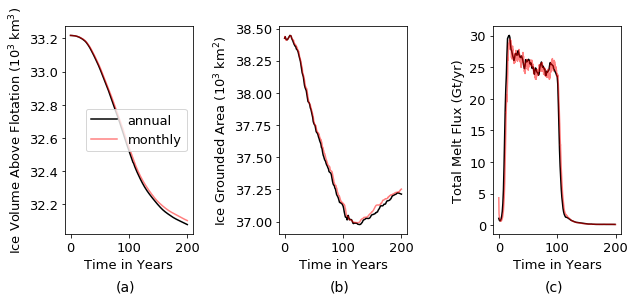

In [12]:
matplotlib.rcParams.update({'font.size': 13})
basedir = '/albedo/work/projects/oce_rio/orichter/uacpl/'

fig,axes = plt.subplots(ncols=3,figsize=(9,4))

ax0,ax1,ax2=axes.flatten()

ax0,VAFa=get_VAF_ax(ax0,'io1056','annual')
ax0,VAFm=get_VAF_ax(ax0,'io1057','monthly','r',0.5)

ax1,Aa=get_grArea_ax(ax1,'io1056','annual')
ax1,Am=get_grArea_ax(ax1,'io1057','monthly',color='r',alpha=0.5)
ax2,time,bmba = get_bmbIce_ax(ax2,'io1056','annual')
ax2,time,bmbm = get_bmbIce_ax(ax2,'io1057','monthly','r',0.5)
ax0.legend()
#ax0,ax1,ax2,ax3=axes[2,:].flatten()
#ax0=get_center_ax(ax0,'io1056','')
for ax,label in zip(axes.flatten(),['(a)', '(b)', '(c)']):
    ax.text(0.55, -0.22, label, transform=ax.transAxes,
      fontsize=14, va='top', ha='right')

#ax.plot(np.cumsum(bmb_ice[:-2]-bmb_oce),label='cumsum')
plt.tight_layout()
plt.savefig('./figures/monthlyCouplingEffect.pdf',bbox_inches='tight',backend='pgf')
plt.show()

In [26]:
print(VAFm[-1]-VAFa[-1])
print(Am[-1]-Aa[-1])
print(bmbm[-1]-bmba[-1])

<xarray.DataArray 'iceVAF' ()>
array(0.023973)
<xarray.DataArray 'groundedArea' ()>
array(0.039207)
-0.015270577320822376


Done reading bmb file


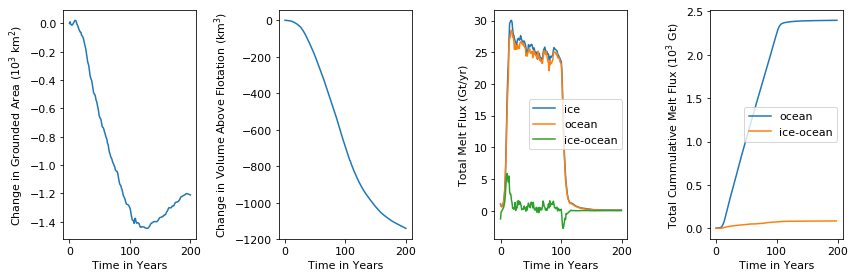

In [122]:
fig,axes = plt.subplots(nrows=1,ncols=4,figsize=(12,4))
ax0,ax1,ax2,ax3=axes.flatten()
ax0=get_grAreaChange_ax(ax0,'io1056','')
ax1=get_VAFChange_ax(ax1,'io1056','')
ax2,time,bmb_ice = get_bmbIce_ax(ax2,'io1056','ice')
bmb_oce=get_bmbOce('io1056',np.arange(1000,1200,1))
ax2.plot(bmb_oce[1:],label='ocean')
ax2.plot(bmb_ice-bmb_oce,label='ice-ocean')
ax2.legend()
ax3=get_bmbCumComp_ax(ax3,bmb_ice,bmb_oce,time)
#ax.plot(np.cumsum(bmb_ice[:-2]-bmb_oce),label='cumsum')
plt.tight_layout()
#plt.savefig('./figures/idealisedIntegratedQuantities.png')
plt.show()